# BERT embeddings

## Instalations and imports

In [3]:
!pip install sentence_transformers

     |████████████████████████████████| 78 kB 3.9 MB/s 
     |████████████████████████████████| 3.4 MB 11.3 MB/s 
     |████████████████████████████████| 3.3 MB 48.7 MB/s 
     |████████████████████████████████| 1.2 MB 53.1 MB/s 
     |████████████████████████████████| 61 kB 532 kB/s 
     |████████████████████████████████| 895 kB 57.1 MB/s 
     |████████████████████████████████| 596 kB 38.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=62484b7cfc1b5571694a4b18728670846c206ba487b09272e32a5405417e5bca
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
from google.colab import drive
drive.mount('/content/drive')
PROJECT_ROOT = '/content/drive/MyDrive'

import os 
os.chdir(PROJECT_ROOT)
DATA_PATH = os.path.join(PROJECT_ROOT, 'Quotebank_limunADA')

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

from textblob import TextBlob

import torch 
import torch.nn as nn 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt 
import numpy as np 
import scipy
import pickle
import bz2
import json
from operator import itemgetter 


Mounted at /content/drive


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Text prepocessing

In [5]:
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)

    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)

    return lda_tokens


def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    

def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens


## Generating tokens and embeddings for quotes

In [6]:
# Loading tokens from a file
def get_tokens_per_quote(path_to_file, print_step=5e4, num_instances=None):

    tokens_per_quote = {}
    # Iterate through the quotes
    with bz2.open(path_to_file, 'rb') as s_file:
        for i, instance in enumerate(s_file):
            if i % int(print_step) == 0:
                print(f'Instance {i}')

            if num_instances is not None:
                if i == num_instances:
                    break 

            # loading a sample and checking the speaker
            instance = json.loads(instance) 
            tokens = prepare_text_for_lda(instance['quotation'])

            tokens_per_quote[instance['quoteID']] = tokens 
    
    return tokens_per_quote

# Loading quotes at given indexes from a file
def get_instances_at_indexes(path_to_file, indexes=None, print_step=5e4):
    instances = []
    # Iterate through the quotes
    with bz2.open(path_to_file, 'rb') as s_file:
        for i, instance in enumerate(s_file):
            if i % int(print_step) == 0:
                print(f'Instance {i}')
                
            if indexes is None or i in indexes:
                instance = json.loads(instance) 
                instances.append(instance['quotation'])
            else:                
                continue 

    return instances

In [7]:
def load_tokens_string_per_quote(party, year, load_tokens_per_quote=True):
  """
  Given a party and a year loads all the tokens per quote such that each 
  quote is assigned to a string that is concatenation of tokens and spaces. 
  Additionally, if load_tokens_per_quote is false, than generates all the tokens
  """

  # Get path to json file to cleaned data from Quotebank
  path_to_file = os.path.join(  
      DATA_PATH, f'quotes-{party}-{year}.json.bz2'
      )

  # Make new directory if necessary
  os.makedirs(os.path.join(DATA_PATH, 'SBERT'), exist_ok=True) 

  # Get path to file with tokens
  path_to_tokens = os.path.join(
      DATA_PATH, 'SBERT', f'tokens_per_quote_strings_{party}_{year}.pkl'
      )

  # Check if we should only load or generate tokens
  if not load_tokens_per_quote:
    # Get tokens for each quote
    tokens_per_quote = get_tokens_per_quote(
        path_to_file, num_instances=None
        )
   
    # For each quote generate a string from all the tokens by concatenation
    tokens_per_quote_strings = \
        [' '.join(quote) for k, quote in tokens_per_quote.items()]
  
    # Save all the tokens
    pickle.dump(
        tokens_per_quote_strings, 
        open(path_to_tokens, 'wb')
        )
    
  else:
    # Load tokens
    print(f'Loading {party}_tokens_per_quote_strings...')
    tokens_per_quote_strings = pickle.load(
        open(path_to_tokens, 'rb')          
        )
  
  return tokens_per_quote_strings
    


In [8]:
def load_quotes(party, year, load_quotes=True):
  """
  Given a party and a year, loads all the quotes as a list of strings
  """
  # Get a path to json file to cleaned data from Quotebank
  path_to_file = os.path.join(  
      DATA_PATH, f'quotes-{party}-{year}.json.bz2'
      )

  # Get a path to output file where quotes will be stored so the access to them
  # is more efficient
  path_to_quotes_list = os.path.join(
      DATA_PATH, 'SBERT', f'quotes_list_{party}_{year}.pkl'
      )

  if not load_quotes:
    # Load all the quotes from initial file
    quotes = get_instances_at_indexes(path_to_file)
      
    # Store all the quotes 
    pickle.dump(
        quotes, 
        open(path_to_quotes_list, 'wb')
        ) 
    
  else:
    print(f'Loading {party}_quotes...')
    quotes = pickle.load(
        open(path_to_quotes_list, 'rb')
        )
  
  return quotes
   



In [9]:
def load_embeddings(party, year, load_embeddings=True):
  """
  Given a party and a year returns a list of embeddings for each quote
  Additionally, if load embeddings is false than it generates all the embeddings
  and stores it.
  """

  # Get path to file with the embeddings
  path_to_embeddings = os.path.join(
    DATA_PATH, 'SBERT', f'embeddings_{party}_{year}.pkl'
    )

  # Check if embeddings should be generated
  if not load_embeddings:
    # Loads all the tokens 
    tokens_per_quote_strings = load_tokens_string_per_quote(party, year, load_tokens_per_quote=True)

    # Generates all the embeddings by using SentenceTransfromer model    
    embeddings = model.encode(
        tokens_per_quote_strings,
        show_progress_bar=True,
        device=DEVICE,
        batch_size=32 if str(DEVICE) == 'cuda' else 1
        )
    
    # Store all the embeddings 
    pickle.dump(
        embeddings, 
        open(path_to_embeddings, 'wb')
        ) 

  else:
    print(f'Loading {party}_embeddings...')
    # Loads the embeddings
    embeddings = pickle.load(
        open(path_to_embeddings, 'rb')
        )
    
  # Returns embeddings
  return embeddings


In [101]:
### Loading quotes and embeddings
for year in range(2015, 2020+1):
  for party in ['republicans', 'democrates']:
    tokens_string = load_tokens_string_per_quote(party, year, load_tokens_per_quote=True)
    quotes = load_quotes(party, year, load_quotes=True)
    embeddings = load_embeddings(party, year, load_embeddings=False)

print('Done')

Done


## Generating embeddings for topics

In [11]:
def get_topic_embeddings(topics, model):
  """
  Generates topic embeddings from pretrained model
  """
  topics_embeddings = model.encode(
      topics, show_progress_bar=True, device=DEVICE, batch_size=1
      )
    
  return topics_embeddings


TOPICS = [
    'politics', 'economy', 'education', 'health', 'crime'
    ,'russia', 'korea', 'trump', 'china', 
    'drug addiction', 'climate change', 'racism', 'terrorism',
    'illegal immigration', 'sexism', 'affordability of healthcare',
    'affordability of college education', 'economic inequality', 
    'job opportunities'
    ]

topics_embeddings = get_topic_embeddings(TOPICS, model)

print(topics_embeddings.shape)

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

(19, 384)


## Functions for topic detection

In [12]:
def get_similarities_per_topic(party, year, topics=TOPICS):
    """
    For a given party and a year, it returns a dictionary where key is a topic
    and a value is another dictionary with keys 'indexes' and 'sorted'.


    """

    compute_cosine_similarity = nn.CosineSimilarity(dim=1, eps=1e-6)
    similarities_per_topic = {}

    embeddings = load_embeddings(party, year)

    for topic, topic_embedding in zip(topics, topics_embeddings):
        print(topic)

        similarities_per_topic[topic] = {}

        similarities = compute_cosine_similarity(
            torch.from_numpy(embeddings), 
            torch.from_numpy(topic_embedding)
            )

        similarities_per_topic[topic]['sorted'], \
        similarities_per_topic[topic]['indexes'] = \
            torch.sort(similarities, descending=True)

    return similarities_per_topic

def get_similar_quotes(all_quotes, similarities_per_topic, topic, threshold):
    """
    From given list of all quotes returns sublist of quotes such that cosine distance of the embedding
    of quote and topic is less than treshold, based on similarities_per_topic
    """
    should_keep = np.where(
        similarities_per_topic[topic]['sorted'] > threshold
        )[0]

    kept_indexes = similarities_per_topic[topic]['indexes'][should_keep]

    kept_quotes = itemgetter(*kept_indexes)(all_quotes)

    return kept_quotes

def get_num_ratio_of_similar_quotes(all_quotes, similarities_per_topic, topic, threshold):
  similar_quotes = get_similar_quotes(all_quotes, similarities_per_topic, topic, threshold)
  num = len(similar_quotes)
  ratio = len(similar_quotes) / len(all_quotes)
  return num, ratio

"""
# Never used
def get_analysis_of_similar_quotes(all_quotes, similarities_per_topic, topic, threshold):
  similar_quotes = get_similar_quotes(all_quotes, similarities_per_topic, topic, threshold)
  print(f'Length {len(similar_quotes)}')
  print(f'Ratio {len(similar_quotes) / len(all_quotes)}')
  get_sentiment = lambda x: 1 if x > 0.3 else (0 if x > -0.3 else -1)
  sentiments = np.array([get_sentiment(TextBlob(quote).sentiment.polarity) for quote in similar_quotes])
  print(f'Procentage of postive {np.mean(sentiments == 1)*100}%')
  print(f'Procentage of neutral {np.mean(sentiments == 0)*100}%')
  print(f'Procentage of negative {np.mean(sentiments == -1)*100}%')
  return
"""



## Finding thresholds

In this section we generate files for randomly chosen year for example 2019, and for randomly chosen party, for example democrates, in order to seek for appropriate thresholds for similarities.

In [13]:
def print_quotes_for_topic(
    all_quotes, 
    topic, 
    similarities_per_topic, 
    file,
    num_to_print=None
    ):
    """
    Write sample of all_quotes of size num_to_print and their similarites to given topic in the file.
    If num_to_print is None writes all the quotes.
    """

    num_quotes = len(similarities_per_topic[topic]['indexes'])
    if num_to_print is None:
        num_to_print = num_quotes
    step = num_quotes / num_to_print

    sampling = np.arange(0, num_quotes-1, step)


    should_keep = list(np.array(
        similarities_per_topic[topic]['indexes'][sampling],
        ))

    kept_similarities = similarities_per_topic[topic]['sorted'][sampling]
    kept_quotes = itemgetter(*should_keep)(all_quotes)

    with open(file, 'w') as f:
      f.write(f'{topic}\n')
      for i in range(len(kept_quotes)):
        f.write(f'{kept_similarities[i]} {kept_quotes[i]}\n')


In [ ]:
democrates_2019_similarities_per_topic = get_similarities_per_topic('democrates', 2019)
democrates_2019_quotes = load_quotes('democrates', 2019)

os.makedirs(os.path.join(DATA_PATH, 'SBERT', 'example'), exist_ok=True) 

for topic in TOPICS:
  file = os.path.join(DATA_PATH, 'SBERT', 'example', f'{topic}.txt')
  print_quotes_for_topic(democrates_2019_quotes, topic, democrates_2019_similarities_per_topic, file, num_to_print=1000)

Loading democrates_embeddings...
politics
economy
education
health
crime
russia
korea
trump
china
drug addiction
climate change
racism
terrorism
illegal immigration
sexism
affordability of healthcare
affordability of college education
economic inequality
job opportunities
Loading democrates_quotes...


After going through generated files, we conclude the following thresholds.

In [15]:
THRESHOLDS = {
    'affordability of healthcare':0.41, 'china':0.35, 'affordability of college education':0.49,
    'climate change':0.39, 'crime':0.32, 'drug addiction': 0.32, 
    'economy':0.3, 'education':0.37, 'health': 0.38, 'illegal immigration':0.37,
    'job opportunities': 0.35, 'politics': 0.3, 'korea': 0.4, 'racism':0.4, 'russia':0.4, 
    'sexism':0.4, 'terrorism':0.37, 'trump': 0.29, 'economic inequality':0.45
     }


In [74]:
def get_percentages(load=True):
  if load:
    with open('/content/drive/MyDrive/Quotebank_limunADA/SBERT/percentage_of_quotes.json', 'r') as json_file:
      s = json_file.read()
    return json.loads(s)

  YEARS = [str(x) for x in range(2015, 2020+1)]
  PARTIES = ['republicans', 'democrates']

  percentage_of_quotes = {}

  for party in PARTIES:
    percentage_of_quotes[party] = {}
    for year in YEARS:
      percentage_of_quotes[party][year] = {}
      quotes = load_quotes(party, year)
      similarities_per_topic = get_similarities_per_topic(party, year)

      for topic in TOPICS:
        num, per = get_num_ratio_of_similar_quotes(quotes, similarities_per_topic, topic, THRESHOLDS[topic])
        #num_of_quotes[party][year][topic] = num
        percentage_of_quotes[party][year][topic] = per

      print(f'\t{party}-{year} done')

  with open('/content/drive/MyDrive/Quotebank_limunADA/SBERT/percentage_of_quotes.json', 'w') as json_file:
      s = json_file.write(json.dumps(percentage_of_quotes))
  
  return percentage_of_quotes


In [77]:
percentage_of_quotes = get_percentages()

## Plots

### Plotting functions

In [129]:
def plot_rep_dem_during_time(topic, percentage_of_quotes):
    """
    Plots percentage of quotes depending on the time for a given topic for both
    democrates and republicans
    """

    years = [str(x) for x in range(2015, 2020+1)]

    dem_per = np.array([percentage_of_quotes['democrates'][year][topic] for year in years])*100
    rep_per = np.array([percentage_of_quotes['republicans'][year][topic] for year in years])*100
    plt.plot(years, dem_per, label='democrates')
    plt.plot(years, rep_per, label='republicans')
    plt.legend()
    plt.xlabel('year')
    plt.ylabel('percentage of quotes')
    plt.title(topic)
    plt.plot()
    plt.show()

def plot_topics_bar_chart(topics, year, percentage_of_quotes):
    """
    For a given year plots percentages of quotes on given topics for both democrates and republicans
    """
    dem = [percentage_of_quotes['democrates'][year][topic] for topic in topics]
    rep = [percentage_of_quotes['republicans'][year][topic] for topic in topics]

    X_axis = np.arange(len(topics))

    plt.bar(X_axis - 0.2, dem, 0.4, label = 'Democrates')
    plt.bar(X_axis + 0.2, rep, 0.4, label = 'Republicans')

    plt.xticks(X_axis, topics)
    plt.xlabel('Topics')
    plt.xticks(rotation=90, ha='right')
    plt.ylabel('Percentage of quotes about the topic')
    plt.title('Year 2019')
    plt.legend()
    plt.show()

def plot_most_popular_topics(year, percentage_of_quotes, topics, num_of_topics=10):
    """
    Plots most popular topics for a given year among democrates and republicans
    """

    f, ax = plt.subplots(1, 2, sharey=True, figsize = (14, 7))

    for i, party in enumerate(['democrates', 'republicans']):
        topics_popularities = percentage_of_quotes[party][year]

        topics_sorted = sorted(topics, key = lambda x : -topics_popularities[x])[:num_of_topics]
        weights = [topics_popularities[t] for t in topics_sorted]

        ax[i].bar(topics_sorted, weights)
        ax[i].set_xticklabels(topics_sorted, rotation=90)
        ax[i].set_xlabel('topics')
        ax[i].set_ylabel('percentage of quotes')
        ax[i].set_title(f'Statistics for {party} during {year}')
    plt.show()


def plot_most_popular_topics_together(year, percentage_of_quotes, topics, num_of_topics=10):
    """
    Plots most popular topics for a given year among democrates and republicans
    """

    
    topics_popularities_rep = percentage_of_quotes['republicans'][year]
    topics_popularities_dem = percentage_of_quotes['democrates'][year]
    topics_sorted = sorted(
        topics, 
        key = lambda x: -topics_popularities_rep[x]-topics_popularities_dem[x]
        )[:num_of_topics]
    weights_rep = [topics_popularities_rep[t] for t in topics_sorted]

    weights_dem = [topics_popularities_dem[t] for t in topics_sorted]
    weights_rep = [topics_popularities_rep[t] for t in topics_sorted]

    plt.bar(topics_sorted, weights_dem, label='Democrates')
    plt.bar(topics_sorted, weights_rep, bottom=weights_dem, label='Republicans')

    plt.xticks(topics_sorted, rotation=90)
    plt.xlabel('topics')
    plt.ylabel('percentage of quotes')
    plt.title(f'Statistics for {year}')

    plt.legend()
    plt.show()

### Popularity of topics during the time for both political parties

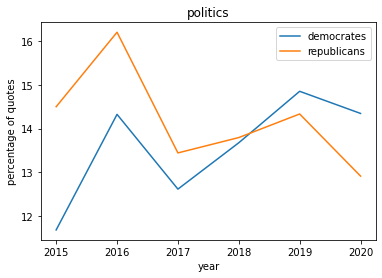

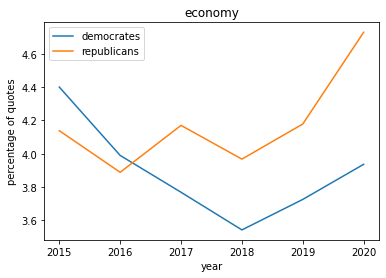

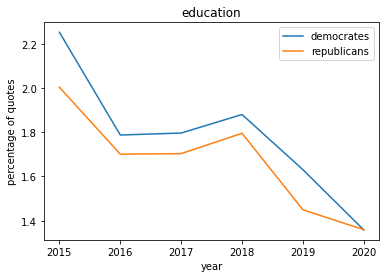

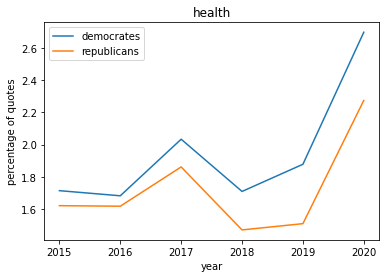

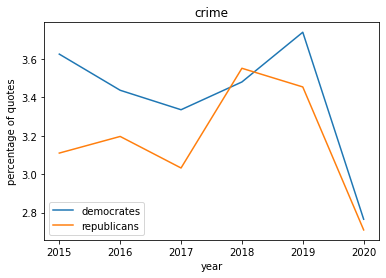

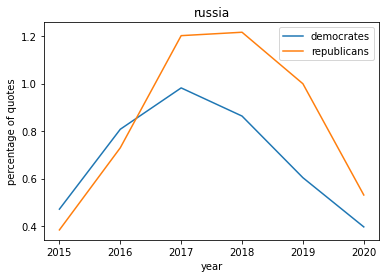

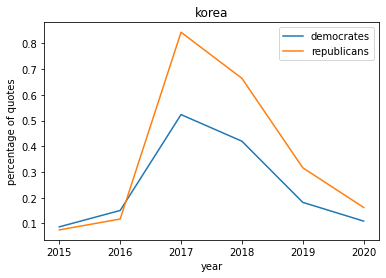

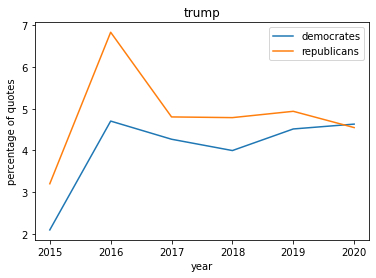

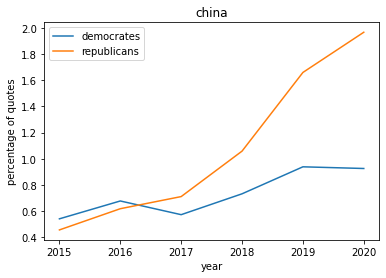

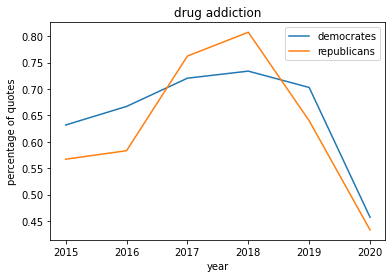

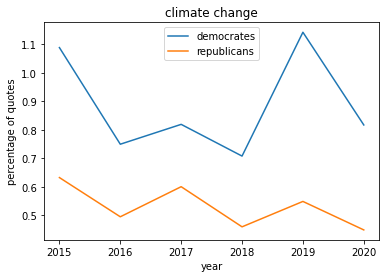

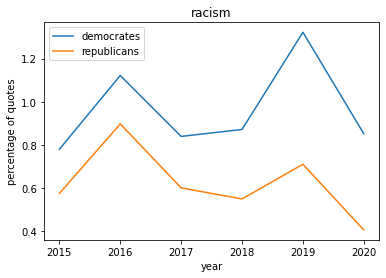

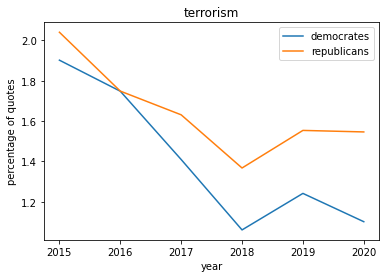

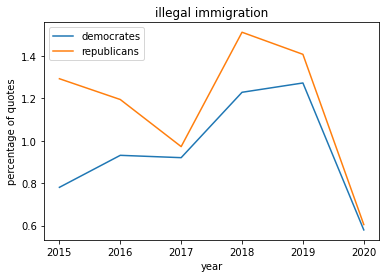

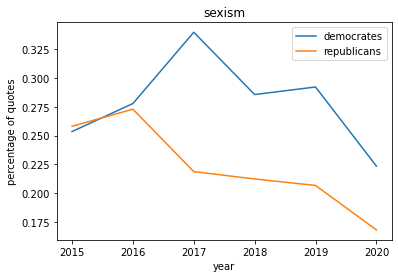

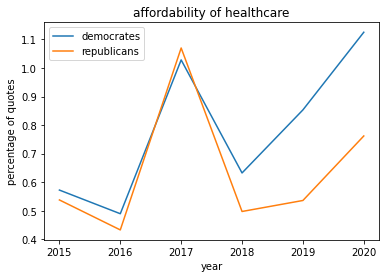

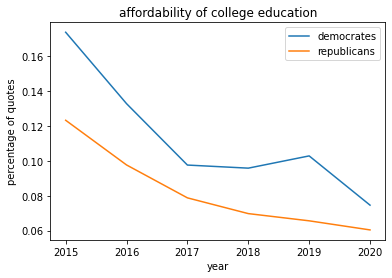

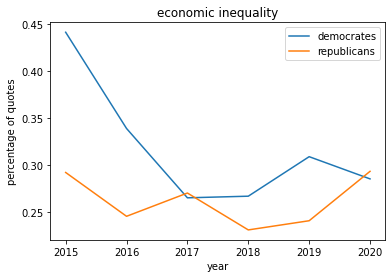

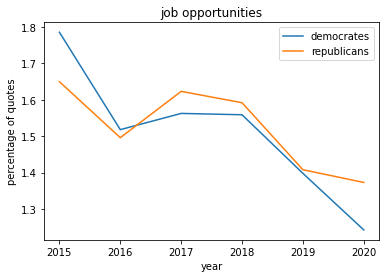

In [71]:
for topic in TOPICS:
  plot_rep_dem_during_time(topic, percentage_of_quotes)


## Comparison of presence of topics between democrates and republicans

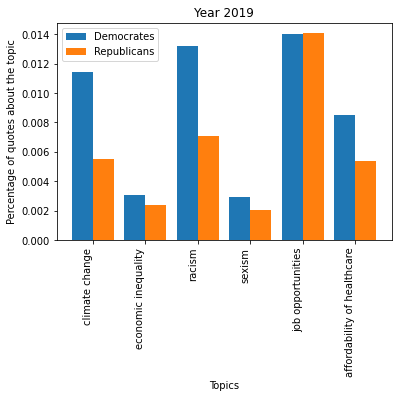

In [97]:
topics1 = ['climate change', 'economic inequality', 'racism', 'sexism', 'job opportunities', 'affordability of healthcare']
plot_topics_bar_chart(topics1, '2019', percentage_of_quotes)

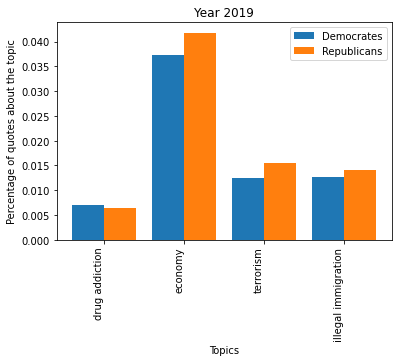

In [98]:
topics2 = ['drug addiction', 'economy', 'terrorism', 'illegal immigration']
plot_topics_bar_chart(topics2, '2019', percentage_of_quotes)

## Most popular topics during the years

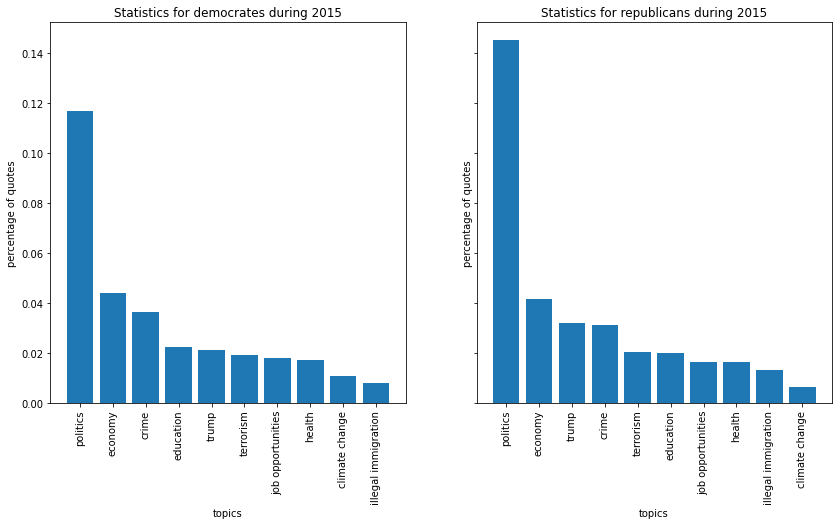

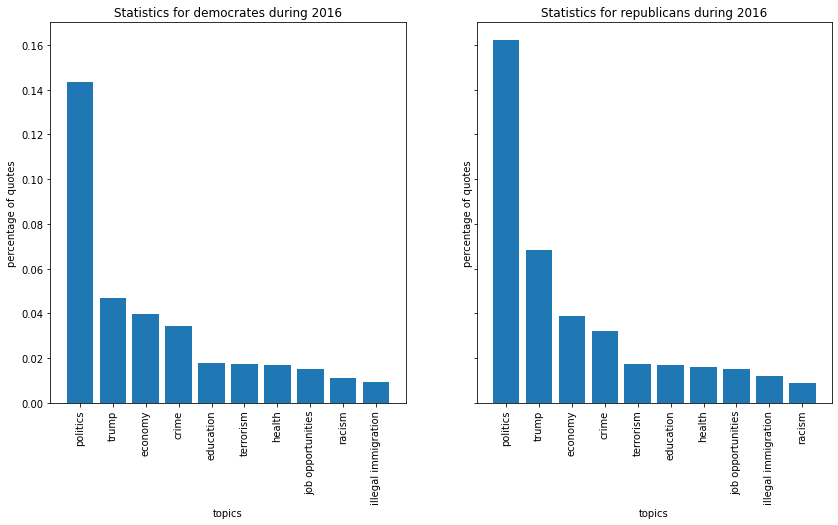

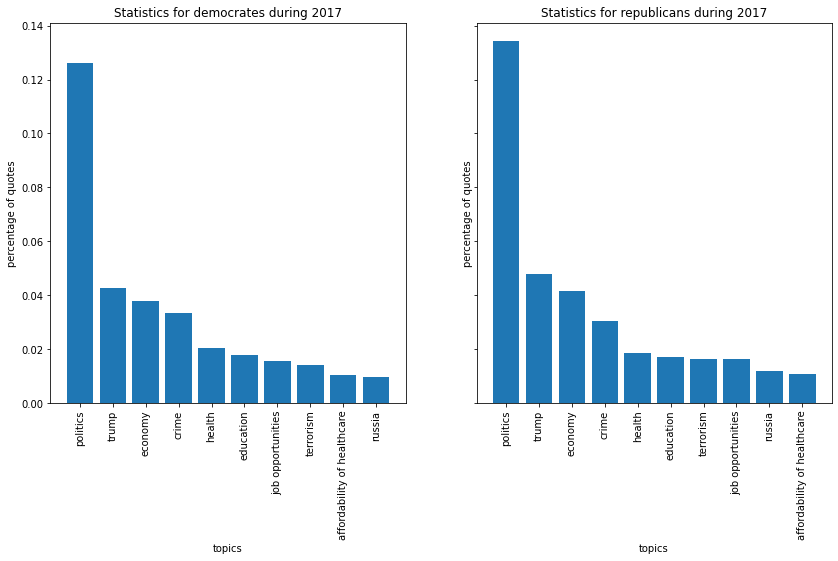

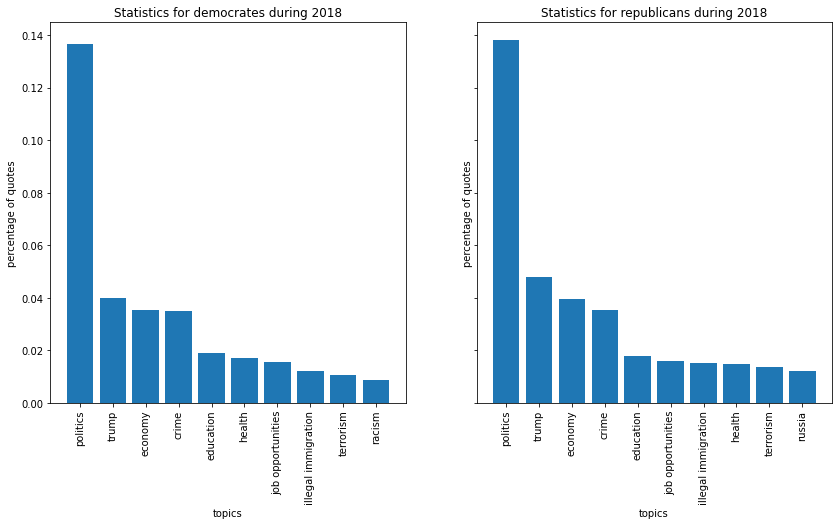

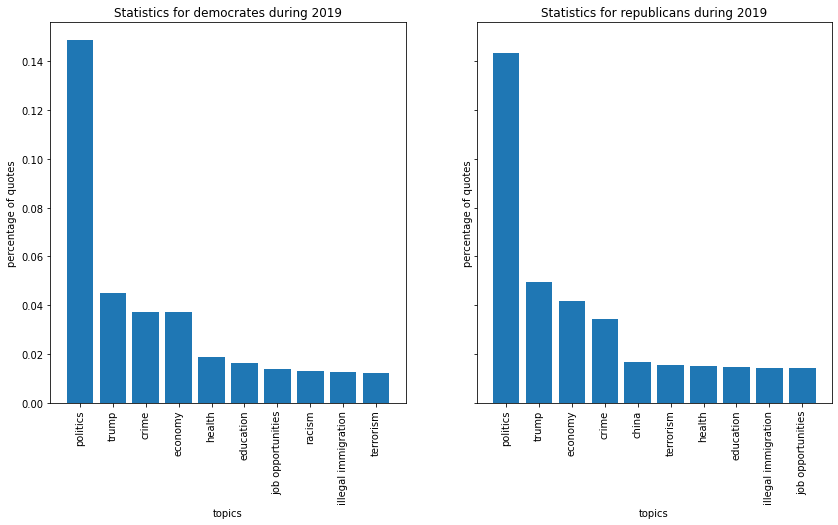

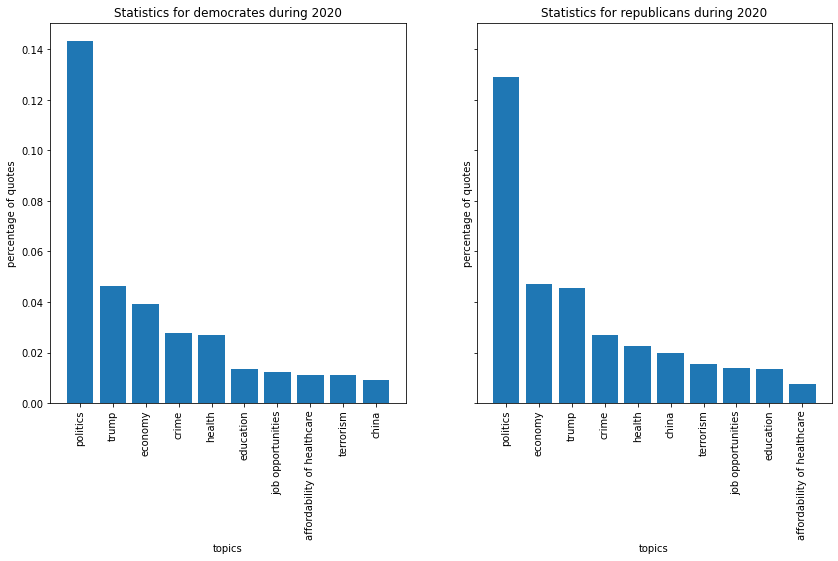

In [124]:
YEARS = ['2015', '2016', '2017', '2018', '2019', '2020']
for year in YEARS:
    plot_most_popular_topics(year, percentage_of_quotes, TOPICS)

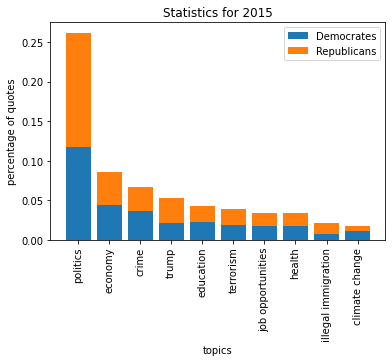

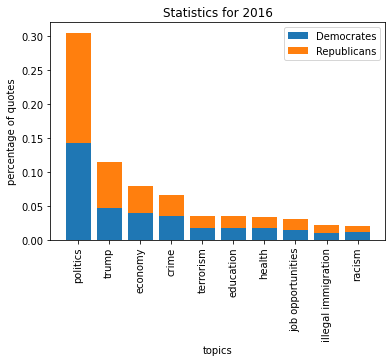

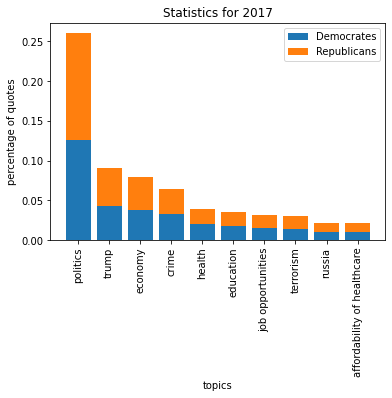

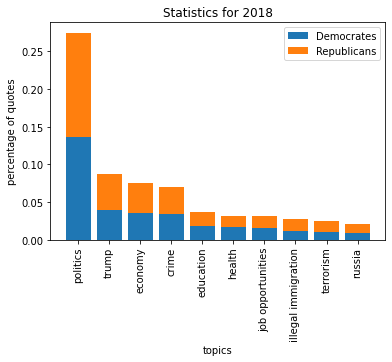

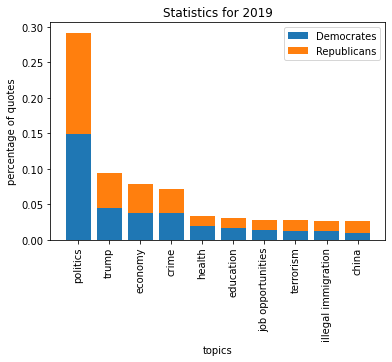

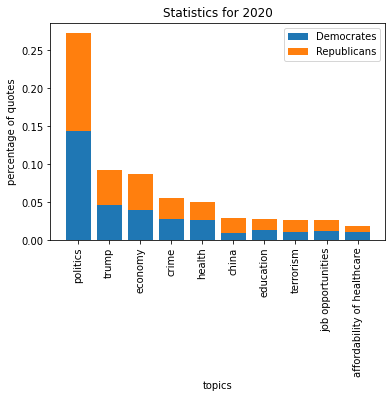

In [130]:
YEARS = ['2015', '2016', '2017', '2018', '2019', '2020']
for year in YEARS:
    plot_most_popular_topics_together(year, percentage_of_quotes, TOPICS)